# Priors

Testing the impact of enforcing a prior on model predictions, such that sum of labels equals one.

In [1]:
# imports 
import matplotlib.pyplot as plt
plt.style.use('thesis')
import numpy as np
from sklearn.metrics import mean_squared_error

In [3]:
# loading data and defining functions
root = "sfh_100_20260123_104514"
real = np.vstack(10**(np.load(f"/avatar/vmehta/{root}/snr__all_true.npy")))

def load_data(sigma):
    if sigma == None:
        pred = np.vstack(10**(np.load(f"/avatar/vmehta/{root}/snr__all_pred.npy")))
    else:
        pred = np.vstack(10**(np.load(f"/avatar/vmehta/{root}/snr__all_pred_sigma_{sigma}.npy")))

    return pred

# Bin setup (used in multiple places)
bin_arr = np.r_[np.array([0.1, 20, 50, 100, 200, 500])*1e6, np.logspace(9.5, 10.15, 5)]
binning = np.log10(bin_arr)
bin_widths = np.diff(binning)
bin_centers = binning[:-1] + bin_widths/2

def rmse(pred):
    rmse = np.sqrt(mean_squared_error(real, pred, multioutput='raw_values'))
    overall_rmse = np.sqrt(mean_squared_error(real, pred))
    return rmse, overall_rmse

## Accuracy
How does enforcing priors impact the accuracy of predicted SFH?

In [4]:
rmse(load_data(None))[1]

np.float64(1.2270511370017219)

FileNotFoundError: [Errno 2] No such file or directory: '/avatar/vmehta/sfh_100_20260123_104514/snr__all_pred.npy'

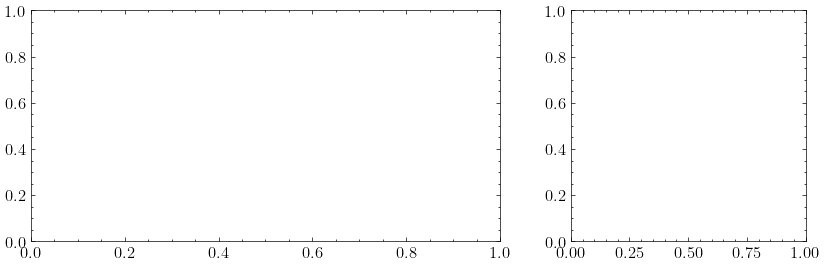

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,3), gridspec_kw={'width_ratios': [2, 1]})

ax[0].plot(bin_centers, rmse(load_data(None))[0], 'ko--')
for s in ["0_1", "0_0_1", "0_0_0_1"]:
    pred = load_data(s)
    ax[0].plot(bin_centers, rmse(pred)[0], marker='o')
ax[0].legend(['No prior', '$\\sigma=0.1$', '$\\sigma=0.01$', '$\\sigma=0.001$'])
ax[0].set_xlabel('$\\log_{10}t_\\mathrm{lookback}$ [years]')
ax[0].set_ylabel('$\\Delta\\ell_\\mathrm{RMSE}$')
ax[0].set_yscale('log')

inset = ax[0].inset_axes([0.05, 0.5, 0.4, 0.4])
inset.plot(bin_centers, rmse(load_data("0_1"))[0], marker='o', markersize=3)
inset.plot(bin_centers, rmse(load_data("0_0_1"))[0], marker='o', markersize=3)
inset.plot(bin_centers, rmse(load_data("0_0_0_1"))[0], marker='o', markersize=3)
inset.tick_params(axis='both', which='major', labelsize=8)

ax[0].indicate_inset_zoom(inset, edgecolor="black")

ax[1].plot([0.1, 0.01, 0.001], [rmse(load_data("0_1"))[1], rmse(load_data("0_0_1"))[1], rmse(load_data("0_0_0_1"))[1]], 'ko-')
ax[1].set_xscale('log')
ax[1].set_xlabel('$\\sigma$')
ax[1].set_ylabel('$\\Delta\\pmb\\ell_\\mathrm{RMSE}$')
ax[1].set_ylim(0.08,0.1)
ax[1].set_xticks([0.1, 0.01, 0.001])
ax[1].set_xticklabels(['0.1', '0.01', '0.001'])
ax[1].text(0.001, 0.081, '($\\Delta\\pmb\\ell_\\mathrm{RMSE}$ for no prior $\\sim10^{22}$)')

plt.tight_layout()
#plt.savefig('/home/vmehta/honours-project/thesis/figures/priors_rmse.pdf')
plt.show()

## Precision
How does enforcing priors impact the label sums? Plot histograms for the sum of all labels.

In [ ]:
def plot_hist(data, ax=None, bins=100, focus_percentile=90.0, color='C0', alpha=0.7, density=False, plotmean=True, plotmed=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    else:
        fig = ax.figure

    data = np.asarray(data)
    data = data[np.isfinite(data)]
    if data.size == 0:
        raise ValueError('data is empty after filtering non-finite values')

    lowp = (100 - focus_percentile) / 2.0
    highp = 100 - lowp
    vmin, vmax = np.percentile(data, [lowp, highp])

    clipped = data[(data >= vmin) & (data <= vmax)]
    ax.hist(clipped, bins=bins, color=color, alpha=alpha, density=density)
    if plotmean:
        ax.axvline(np.mean(data), color='k', linestyle=':', linewidth=1, label='Mean')
    if plotmed:
        ax.axvline(np.median(data), color='k', linestyle='--', linewidth=1, label='Median')

    return ax

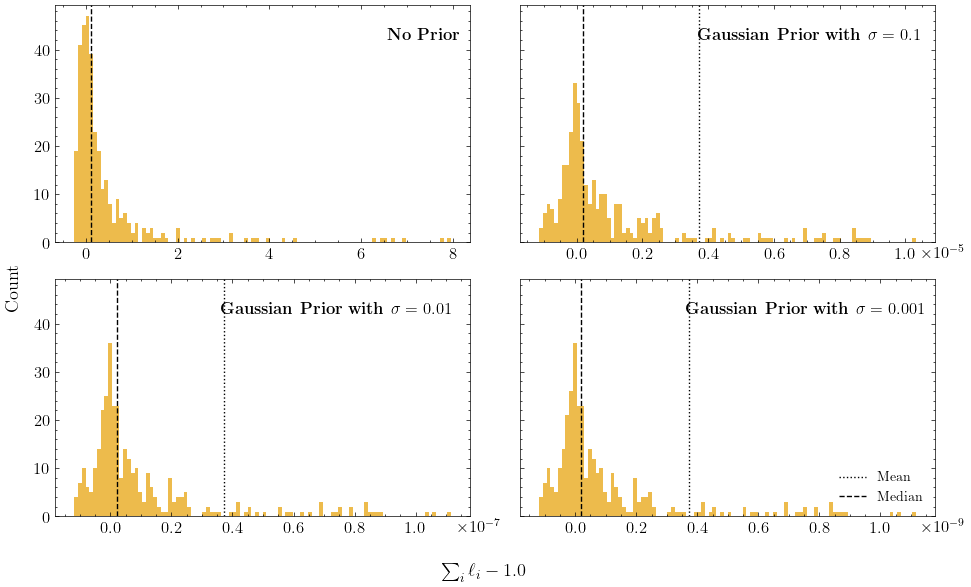

In [ ]:
# having a look at some of the distributions
label_sum_none = np.sum(load_data(sigma=None), axis=1)
label_sum_0_1 = np.sum(load_data(sigma="0_1"), axis=1)
label_sum_0_0_1 = np.sum(load_data(sigma="0_0_1"), axis=1)
label_sum_0_0_0_1 = np.sum(load_data(sigma="0_0_0_1"), axis=1)

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
plot_hist(label_sum_none-1, focus_percentile=84, ax=ax[0, 0], plotmean=False)
plot_hist(label_sum_0_1-1, focus_percentile=84, ax=ax[0, 1])
plot_hist(label_sum_0_0_1-1, focus_percentile=84, ax=ax[1, 0])
plot_hist(label_sum_0_0_0_1-1, focus_percentile=84, ax=ax[1, 1])
fig.supxlabel('$\\sum_i\\ell_i-1.0$')
fig.supylabel('Count')
ax[1,1].legend(loc='lower right', fontsize=10)
ax[0,0].text(0.8, 0.9, '\\textbf{No Prior}', transform=ax[0,0].transAxes, fontsize=12, verticalalignment='top')
ax[0,1].text(0.43, 0.9, '\\textbf{Gaussian Prior with $\\sigma=0.1$}', transform=ax[0,1].transAxes, fontsize=12, verticalalignment='top')
ax[1,0].text(0.4, 0.9, '\\textbf{Gaussian Prior with $\\sigma=0.01$}', transform=ax[1,0].transAxes, fontsize=12, verticalalignment='top')
ax[1,1].text(0.4, 0.9, '\\textbf{Gaussian Prior with $\\sigma=0.001$}', transform=ax[1,1].transAxes, fontsize=12, verticalalignment='top')
ax[0,1].xaxis.get_offset_text().set_visible(False)
ax[0,1].text(0.97, -0.01, '$\\times10^{-5}$', transform=ax[0,1].transAxes, fontsize=12, verticalalignment='top')
ax[1,0].xaxis.get_offset_text().set_visible(False)
ax[1,0].text(0.97, -0.01, '$\\times10^{-7}$', transform=ax[1,0].transAxes, fontsize=12, verticalalignment='top')
ax[1,1].xaxis.get_offset_text().set_visible(False)
ax[1,1].text(0.97, -0.01, '$\\times10^{-9}$', transform=ax[1,1].transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
#plt.savefig('/home/vmehta/honours-project/thesis/figures/prior_histograms.pdf', format='pdf')